# Option 1

In this workflow, the intend is to calibrate the glen parameter A to be the closest from the one of the consensus or of Millan observations.

In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from oggm import cfg, utils, workflow, tasks, graphics,core
import pandas as pd
import numpy as np
from oggm.shop import bedtopo,gcm_climate
import salem

import add_data
import work_tasks
import graph

cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] =  '/home/lucillegimenes/oggm-workflow-b/'
cfg.PARAMS['use_multiprocessing']=True
cfg.PARAMS['store_model_geometry'] = True


utils.get_rgi_dir(version='62')

rgi_ids = ['RGI60-13.37753'] 

# The RGI version to use
# Size of the map around the glacier.
prepro_border = 80
# Degree of processing level. This is OGGM specific and for the shop 1 is the one you want
from_prepro_level = 2
# URL of the preprocessed gdirs
#base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match/'
base_url='https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/match_geod/'

2021-12-09 17:18:50: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-12-09 17:18:50: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-12-09 17:18:50: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-12-09 17:18:50: oggm.cfg: Multiprocessing switched ON after user settings.
2021-12-09 17:18:50: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


## (0) Get Millan volume (to be run only one time to create the .h5 file)

In [235]:
gdirs = workflow.init_glacier_directories(rgi_ids,
                                          from_prepro_level=from_prepro_level,
                                          prepro_base_url=base_url,
                                          prepro_border=prepro_border)
gdir=gdirs[0]

gdir.name_corr=gdir.name.replace('/','-')
if (gdir.name==''):
    gdir.name_corr='Aletsch'
    
    
#Little adjustment  
if (gdir.rgi_region in ['13','14','15']):
    gdir.rgi_region_m='13-15'
else:
    gdir.rgi_region_m=gdir.rgi_region

add_data.add_data_thickness(gdir,'/home/lucillegimenes/Bureau/THICKNESS_Millan/RGI-'+gdir.rgi_region_m+'/per_glacier/'+gdir.rgi_id+'_thickness_m_from_f.tif')
 
    
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
    
#new dataframe to add
vol=int(ds.millan_thickness.where(ds.glacier_mask==1).sum())*(gdir.grid.dx**2)
columns=['volume_m3']
index=[gdir.rgi_id]
df=pd.DataFrame(data=vol,index=index,columns=columns)
df.index.name='RGIId'

old=pd.read_hdf('/home/lucillegimenes/volumes_millan.h5')

new=pd.concat([old,df],axis=0)

#save 
store = pd.HDFStore('volumes_millan.h5')
store.put('dataset_01', new)
store.close()


2021-11-22 17:20:58: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-11-22 17:20:58: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


"columns=['volume_m3']\nindex=[gdir.rgi_id]\ndf=pd.DataFrame(data=vol,index=index,columns=columns)\ndf.index.name='RGIId'\n\nold=pd.read_hdf('/home/lucillegimenes/volumes_millan.h5')\n\nnew=pd.concat([old,df],axis=0)\n\n#save \nstore = pd.HDFStore('volumes_millan.h5')\nstore.put('dataset_01', new)\nstore.close()"

## (0.1) Using the thicknesses from 2000 (or 2010)

### Add and plot elevation change


In [40]:
base_url='https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/match_geod_pergla/'
gdirs = workflow.init_glacier_directories(rgi_ids,
                                          from_prepro_level=3,
                                          prepro_border=prepro_border)
gdir=gdirs[0]



2021-12-08 12:19:56: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-12-08 12:19:56: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


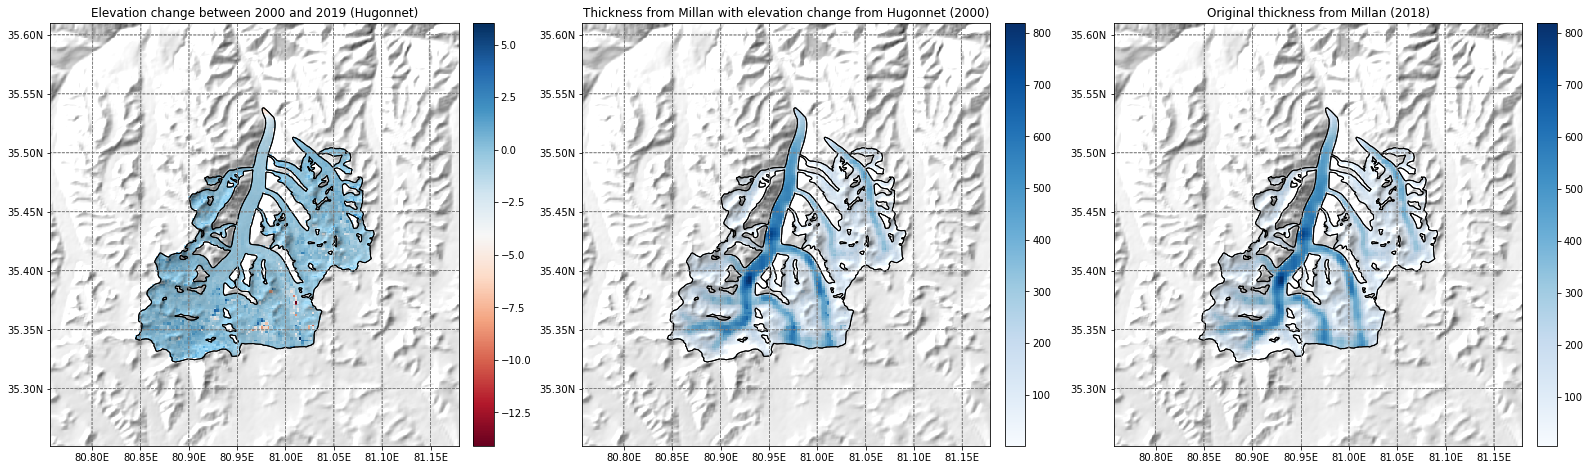

In [44]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(27, 9))
orig_cmap = matplotlib.cm.RdBu
shifted_cmap2 = graph.shiftedColorMap(orig_cmap, midpoint=0.5, name='shifted')


if (gdir.rgi_region in ['13','14','15']):
    gdir.rgi_region_m='13-15'
else:
    gdir.rgi_region_m=gdir.rgi_region

hugonnet='/home/lucillegimenes/Bureau/Elevation_change/RGI-'+gdir.rgi_region_m+'/'+gdir.rgi_id+'_elev_ch.tif'
millan='/home/lucillegimenes/Bureau/THICKNESS_Millan/RGI-'+gdir.rgi_region_m+'/per_glacier/'+gdir.rgi_id+'_thickness_m_from_f.tif'
millan_w_hugonnet='/home/lucillegimenes/Bureau/THICKNESS_Millan/RGI-'+gdir.rgi_region_m+'/per_glacier/'+gdir.rgi_id+'_thickness_2000.tif'

add_data.add_data_thickness(gdir,millan,'millan_thickness','Ice thickness from Millan')
add_data.add_data_thickness(gdir,millan_w_hugonnet,'millan_thickness_new','Ice thickness from Millan updated to 2000')
add_data.add_data_elev(gdir,hugonnet,'elev_change','Elevation change btw 2000 and 2019')

with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

smap = ds.salem.get_map(countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_topography(ds.topo.data);
smap.set_data(ds.elev_change.where(ds.glacier_mask==1))
smap.set_cmap(shifted_cmap2)
smap.plot(ax=ax1)
smap.visualize(ax=ax1,title='Elevation change between 2000 and 2019 (Hugonnet)')

smap2 = ds.salem.get_map(countries=False)
smap2.set_shapefile(gdir.read_shapefile('outlines'))
smap2.set_topography(ds.topo.data);
smap2.set_data(ds.millan_thickness_new.where(ds.glacier_mask==1))
smap2.set_cmap('Blues')
smap2.plot(ax=ax2)
#smap.append_colorbar(ax=ax1, label='ice thickness (m)');
smap2.visualize(ax=ax2,title='Thickness from Millan with elevation change from Hugonnet (2000)')

smap3 = ds.salem.get_map(countries=False)
smap3.set_shapefile(gdir.read_shapefile('outlines'))
smap3.set_topography(ds.topo.data);
smap3.set_data(ds.millan_thickness.where(ds.glacier_mask==1))
smap3.set_cmap('Blues')
smap3.plot(ax=ax3)
mm=max(ds.millan_thickness_new.where(ds.glacier_mask==1).max(),ds.millan_thickness.where(ds.glacier_mask==1).max())
smap3.set_vmax(val=mm)
#smapp.append_colorbar(ax=ax2, label='ice thickness (m)');
smap3.visualize(ax=ax3,title='Original thickness from Millan (2018)')

name = ''+gdir.name+'_panel_thick_elev.png'
plt.savefig(name, format = 'png')


### Checking if everything alright

In [23]:
test=pd.read_hdf('/home/lucillegimenes/volumes_millan.h5')
test

,volume_m3
RGIId,
RGI60-11.01450,16401722337
RGI60-11.03684,408418920
RGI60-11.03643,2457668354
RGI60-11.03638,1179496804
RGI60-14.00005,146864080000
...,...
RGI60-13.52589,2884376152
RGI60-13.52594,5556978966
RGI60-13.52609,735025632


## (1.) Calibrating the volume on the observations

Before running simulations, we have to examine how evolves the ice thickness along the flowline regarding the original thicknesses from Farinotti or Millan

2021-11-30 09:54:50: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-11-30 09:54:50: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2021-11-30 09:54:50: oggm.workflow: Execute entity tasks [add_consensus_thickness] on 1 glaciers


13752318750.0


2021-11-30 09:54:55: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-30 09:54:56: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-30 09:54:56: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 09:54:56: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 09:54:56: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-30 09:54:56: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-30 09:54:56: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-30 09:54:56: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-30 09:54:56: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-30 09:54:56: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-30 09:54:56: oggm.workflow: Execute

KeyError: 'RGI60-11.01450'

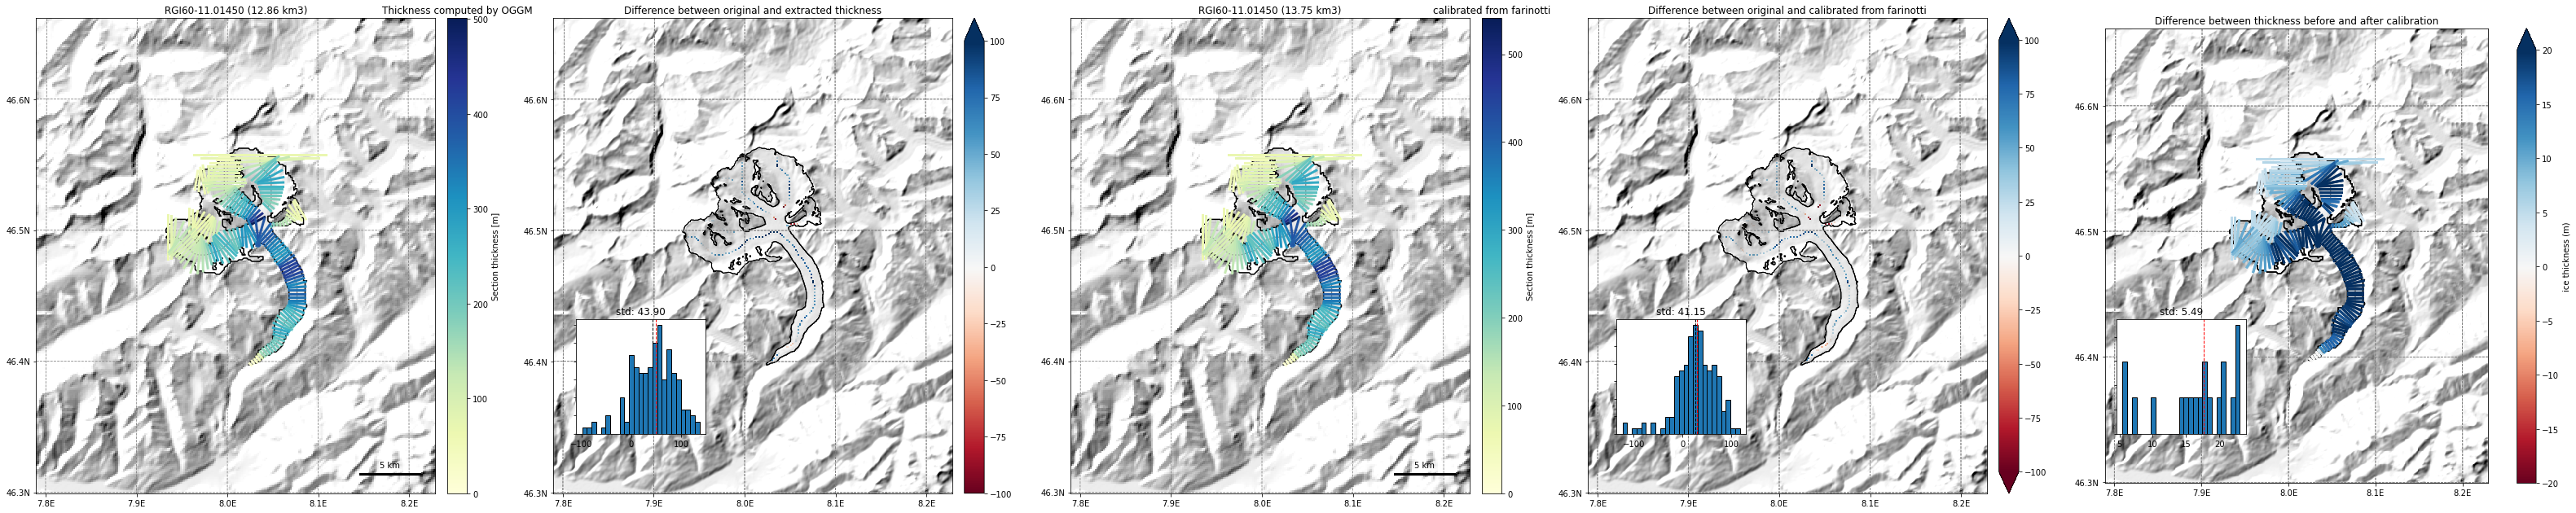

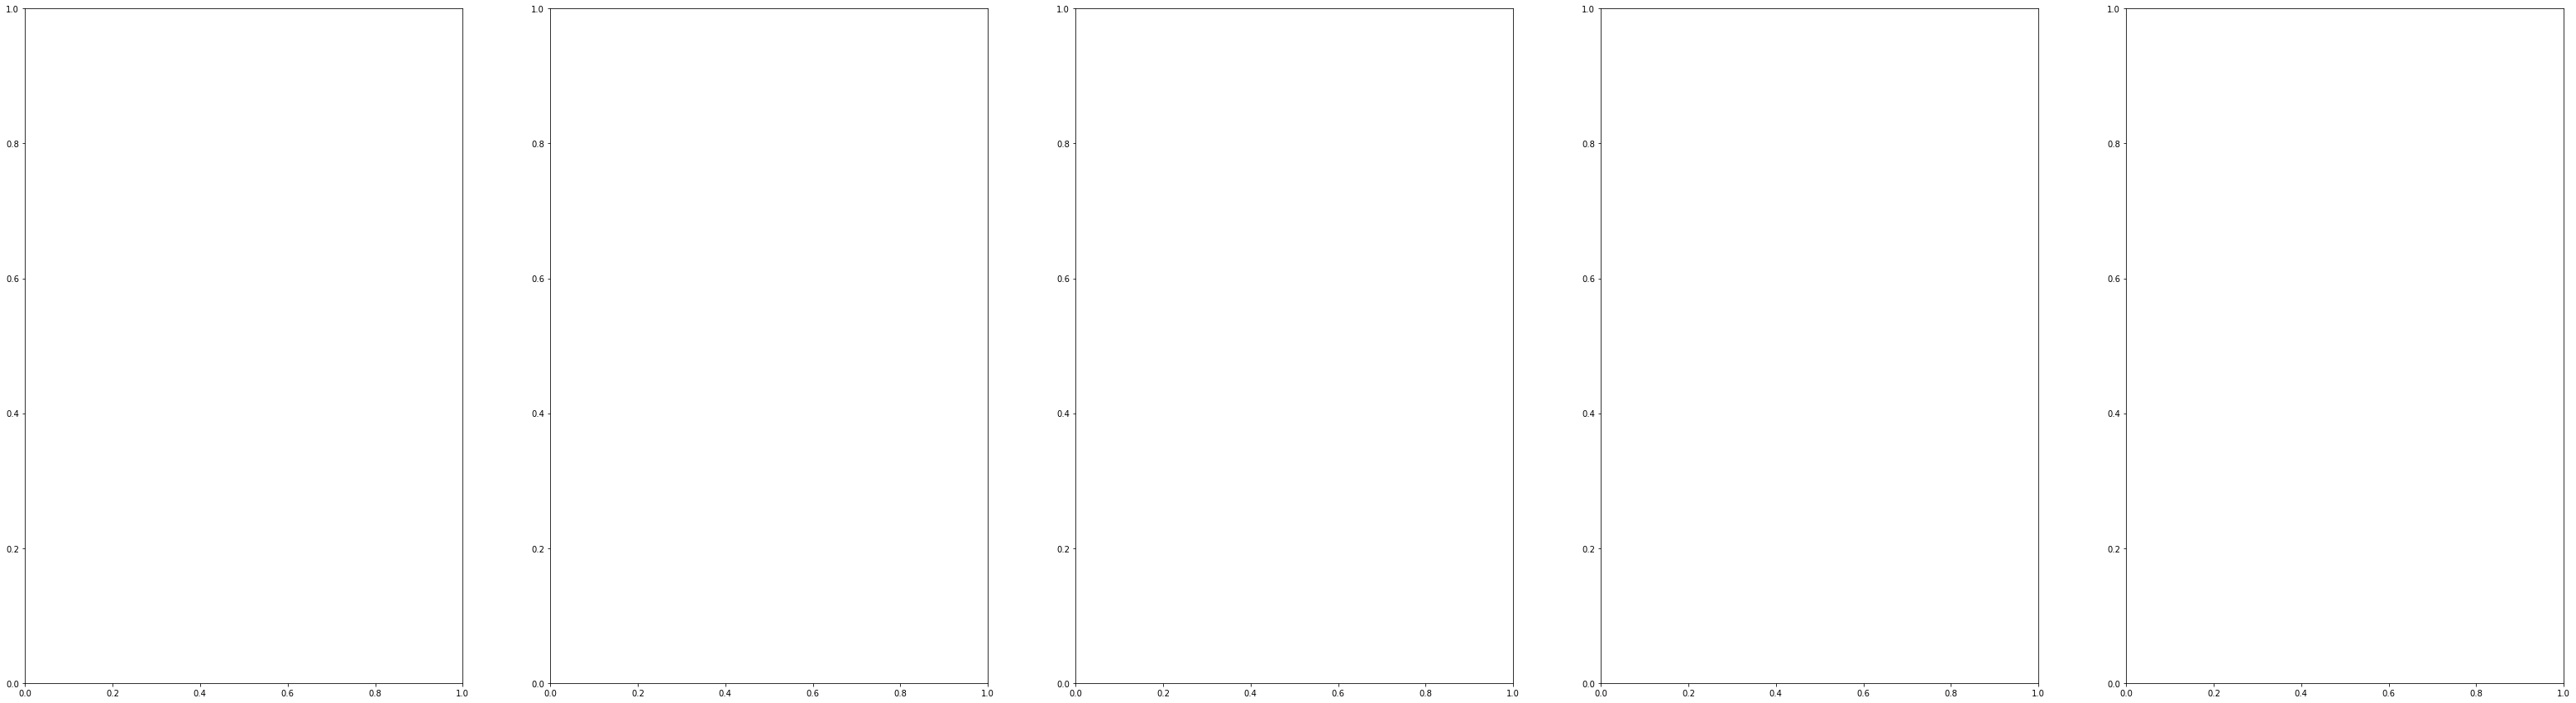

In [11]:
import work_tasks
import statistics

orig_cmap = matplotlib.cm.RdBu
diag={'farinotti':[0,0],'millan':[0,0]}
eps={'farinotti':0,'millan':0}

k=0
path_to_hdf='/home/lucillegimenes/volumes_millan_13_spe_set_2000.h5'

#path_to_hdf='/home/lucillegimenes/volumes_millan.h5'
#path_to_hdf='/home/lucillegimenes/volumes_millan_2000.h5'
#bounds=(0.005,10)
bounds=(0.1,10)

for data in ['farinotti','millan']:
    gdirs = workflow.init_glacier_directories(rgi_ids,from_prepro_level=3,
                                                  prepro_border=prepro_border)
    gdir=gdirs[0]
    
    gdir.name_corr=gdir.name.replace('/','-')
    if (gdir.name==''):
        gdir.name_corr=gdir.rgi_id
    
    f, (ax1, ax2, ax3, ax4, ax5)= plt.subplots(1, 5, figsize=(55, 15))


    if (data=='farinotti'):
        workflow.execute_entity_task(bedtopo.add_consensus_thickness, gdir);
        dff = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))
        vref=dff.loc[gdir.rgi_id,:][0]
        print(vref)
    else:
        #Little adjustment
        if (gdir.rgi_region in ['13','14','15']):
            gdir.rgi_region_m='13-15'
        else:
            gdir.rgi_region_m=gdir.rgi_region

        add_data.add_data_thickness(gdir,'/home/lucillegimenes/Bureau/THICKNESS_Millan/RGI-'+gdir.rgi_region_m+'/per_glacier/'+gdir.rgi_id+'_thickness_m_from_f.tif',
                                   'millan_thickness_2000','Ice thickness from 2000')
        dff=pd.read_hdf(path_to_hdf)
        vref=dff.loc[gdir.rgi_id,:][0]
        print(vref)
    
        
    #f1 Thickness by OGGM
    graphics.plot_inversion(gdir,ax=ax1)
    save_orig = gdir.read_pickle('inversion_output')
    plt.title('Thickness computed by OGGM')
    diag[data][0]= gdir.get_diagnostics()

    add_data.mapped_extracted_thickness(gdir)

    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()
            
    #f2
    smap = ds.salem.get_map(countries=False)
    smap.set_shapefile(gdir.read_shapefile('outlines'))
    smap.set_topography(ds.topo.data);
    if(data=='farinotti'):
        compare_data=ds.consensus_ice_thickness
    else:
        compare_data=ds.millan_thickness_2000
    smap.set_data(compare_data-ds.extracted_thickness_hist)
    shifted_cmap2 = graph.shiftedColorMap(orig_cmap, midpoint=0.5, name='shifted')
    smap.set_cmap(shifted_cmap2)
    smap.set_vmax(val=100)
    smap.set_vmin(val=-100)
    smap.plot(ax=ax2)
    smap.visualize(ax=ax2,title='Difference between original and extracted thickness')
    ax11 = f.add_axes([0.2925, 0.3, 0.04, 0.13])
    ax11.set_yticklabels([])
    var=compare_data-ds.extracted_thickness_hist
    var.plot.hist(bins=25,edgecolor='k',density=True)
    plt.axvline(var.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(var.median(), color='r', linestyle='dashed', linewidth=1)
    std=float(var.std())
    plt.title('std: {:.2f}'.format(std))

    #f3
    if (data=='farinotti'):
        workflow.calibrate_inversion_from_consensus(gdir,apply_fs_on_mismatch=True)
    else:
        work_tasks.calibrate_inversion_from_millan(gdir,path_to_hdf,apply_fs_on_mismatch=True,a_bounds=bounds)
    save_calibrated=gdir.read_pickle('inversion_output')
    graphics.plot_inversion(gdir,ax=ax3)
    plt.title('calibrated from '+data+'')
    diag[data][1] = gdir.get_diagnostics()
    

    add_data.mapped_extracted_thickness(gdir)

    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()
    #f4
    if(data=='farinotti'):
        compare_data=ds.consensus_ice_thickness
    else:
        compare_data=ds.millan_thickness_2000
    smap2 = ds.salem.get_map(countries=False)
    smap2.set_shapefile(gdir.read_shapefile('outlines'))
    smap2.set_topography(ds.topo.data);
    smap2.set_data(compare_data-ds.extracted_thickness_hist)
    shifted_cmap2 = graph.shiftedColorMap(orig_cmap, midpoint=0.5, name='shifted')
    smap2.set_cmap(shifted_cmap2)
    smap2.plot(ax=ax4)
    smap2.set_vmax(val=100)
    smap2.set_vmin(val=-100)
    smap2.visualize(ax=ax4,title='Difference between original and calibrated from '+data+'')
    ax12 = f.add_axes([0.615, 0.3, 0.04, 0.13])
    ax12.set_yticklabels([])
    var=compare_data-ds.extracted_thickness_hist
    var.plot.hist(bins=25,edgecolor='k',density=True)
    plt.axvline(var.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(var.median(), color='r', linestyle='dashed', linewidth=1)
    std=float(var.std())
    plt.title('std: {:.2f}'.format(std))
    
    #f5
    for c,d in zip(save_calibrated,save_orig):
        c['thick']=c['thick']-d['thick']
        
    pkl_diff=save_calibrated 
    graph.plot_inversion_diff(gdirs,pkl_diff,ax=ax5)
    diff_hist=[]
    for n in range(0,len(pkl_diff)):
        diff_hist+=pkl_diff[0]['thick'].tolist()
        
    ax13 = f.add_axes([0.77, 0.3, 0.04, 0.13])
    ax13.set_yticklabels([])
    var=diff_hist
    plt.hist(var,bins=25,edgecolor='k',density=True)
    med = statistics.median(var)
    std = statistics.stdev(var)
    plt.axvline(med, color='r', linestyle='dashed', linewidth=1)
    std=float(std)
    plt.title('std: {:.2f}'.format(std))

    
    
    
    name = ''+gdir.name_corr+'_panel_'+data+'_task1_2000.png'
    plt.savefig(name, format = 'png')
        
    v = tasks.mass_conservation_inversion(gdir, glen_a=diag[data][1]['inversion_glen_a'], write=False)
    diff = ((v-vref)/vref)*100
    eps[data]=diff
        

## 2. Running simulations based on the calibration

In [2]:

cfg.add_to_basenames('model_geometry_my_spinup','model_geometry_my_spinup.nc')
cfg.add_to_basenames('model_geometry_with_spinup','model_geometry_with_spinup.nc')
for rcp in ['rcp26','rcp45','rcp60','rcp85']:
    cfg.add_to_basenames('model_geometry_CCSM4_'+rcp+'','model_geometry_CCSM4_'+rcp+'.nc')
    cfg.add_to_basenames('model_diagnostics_CCSM4_'+rcp+'','model_diagnostics_CCSM4_'+rcp+'.nc')

In [3]:
for ssp in ['ssp126','ssp534-over','ssp585']:
    cfg.add_to_basenames('model_geometry_MRI-ESM2-0_'+ssp+'','model_geometry_MRI-ESM2-0_'+ssp+'.nc')
    cfg.add_to_basenames('model_diagnostics_MRI-ESM2-0_'+ssp+'','model_diagnostics_MRI-ESM2-0_'+ssp+'.nc')

In [4]:
cfg.add_to_basenames('model_geometry_no_spinup','model_geometry_no_spinup.nc')

In [5]:
#download and process gcm data (RCP)
#precipitations
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
#temperatures
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'

In [6]:
#download and process gcmbdata with SSP

bp_s='https://cluster.klima.uni-bremen.de/~oggm/cmip6/GCM/MRI-ESM2-0/MRI-ESM2-0_{}_r1i1p1f1_pr.nc'
bt_s='https://cluster.klima.uni-bremen.de/~oggm/cmip6/GCM/MRI-ESM2-0/MRI-ESM2-0_{}_r1i1p1f1_tas.nc'

In [9]:
import work_tasks
from oggm.core import climate, massbalance, flowline

import time
# start time !
start_time = time.time()


#Pre-allocate
out_evol={'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_evol_no_spin = {'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}


out_hydro_hist = {'oggm':0,'farinotti':0,'millan':0}
out_hydro_hist_no_spin = {'oggm':0,'farinotti':0,'millan':0}

list_out_surf=[0]*3 
list_out_bed=[0]*3
list_out_surf_evol=[0]*9
list_out_bed_evol=[0]*3
list_out_surf_evol_ex=[0]*5

d_=[0,0,0]
#bounds=(0.1,10)
bounds=(0.005,10)
#path_to_hdf='/home/lucillegimenes/volumes_millan_2000.h5'
path_to_hdf='/home/lucillegimenes/volumes_millan_13_spe_set_2000.h5'
#path_to_hdf='/home/lucillegimenes/volumes_millan_13_spe_set.h5'


k=0
data_list=['oggm','farinotti','millan']
for data in data_list:
    print(data)
    gdirs = workflow.init_glacier_directories(rgi_ids,from_prepro_level=from_prepro_level,
                                                  prepro_border=prepro_border)
    
    gdir=gdirs[0]
    
    #climate tasks 
    tasks.process_climate_data(gdir)
    params_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5'
    workflow.download_ref_tstars(base_url=params_url)

    climate_task_list = [tasks.local_t_star, tasks.mu_star_calibration]
        

    for task in climate_task_list:
        workflow.execute_entity_task(task, gdir)

        
    # list of inversion tasks
    inv_task_list = [tasks.prepare_for_inversion,tasks.mass_conservation_inversion,
        tasks.filter_inversion_output]

    # run all inversion tasks
    for task in inv_task_list:
        workflow.execute_entity_task(task, gdir)
    

    gdir.name_corr=gdir.name.replace('/','-')
    if (gdir.name==''):
        gdir.name_corr='Aletsch'
        
    #Little adjustment
    if (gdir.rgi_region in ['13','14','15']):
        gdir.rgi_region_m='13-15'
    else:
        gdir.rgi_region_m=gdir.rgi_region
        
    #Calibration error_on_mismatch=False
    if (data=='farinotti'):
        work_tasks.calibrate_inversion_from_consensus(gdir,vol_bias=1,apply_fs_on_mismatch=True,error_on_mismatch=False)
        workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)
    elif(data=='millan'):
        work_tasks.calibrate_inversion_from_millan(gdir,path_to_hdf,vol_bias=1,apply_fs_on_mismatch=True,error_on_mismatch=False,
                                                   a_bounds=bounds)
        workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)
     
        
    for sp in ['spin']:
        
        #workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)
        
        if(sp=='no_spin'):
            # Run a past climate run based on this spinup
            workflow.execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                    climate_filename='climate_historical', 
                                    ys=2003, ye=2020,
                                    output_filesuffix='_with_spinup',store_monthly_hydro=True)
            with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix='_with_spinup')) as dhn:
                dhn = dhn.load()

            out_hydro_hist_no_spin[data]=dhn
            
        
        elif (sp=='spin'):

                #Run the spinup simulation - t* climate    
            workflow.execute_entity_task(tasks.run_constant_climate, gdir,nyears=200,output_filesuffix='_my_spinup') 

            utils.compile_glacier_statistics(gdir)
            d_[k] = utils.compile_run_output(gdir, input_filesuffix='_my_spinup')


                # Run a past climate run based on this spinup
            workflow.execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                            climate_filename='climate_historical', init_model_filesuffix='_my_spinup',
                                            ys=2003,ye=2020,
                                            output_filesuffix='_with_spinup',store_monthly_hydro=True)

            with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix='_with_spinup')) as dh:
                dh = dh.load()

            out_hydro_hist[data]=dh


            
             #For plotting the initial profile
            fmod = flowline.FileModel(gdir.get_filepath('model_geometry_with_spinup'))
            fl = fmod.fls[-1]  # Main flowline
            i, j = fl.line.xy  # xy flowline on grid
            lons, lats = gdir.grid.ij_to_crs(i, j, crs='EPSG:4326')  # to WGS84

            df_coords = pd.DataFrame(index=fl.dis_on_line*gdir.grid.dx)
            df_coords.index.name = 'Distance along flowline'
            df_coords['lon'] = lons
            df_coords['lat'] = lats
            df_coords['bed_elevation'] = fl.bed_h

            df_thick = pd.DataFrame(index=df_coords.index)
            df_surf_h = pd.DataFrame(index=df_coords.index)
            df_bed_h = pd.DataFrame()

            for year in range(2018, 2020):
                fmod.run_until(year)
                fl = fmod.fls[-1]
                df_thick[year] = fl.thick
                df_surf_h[year] = fl.surface_h

            list_out_surf[k]= df_surf_h[[2018]]
            list_out_bed[k]=df_coords['bed_elevation']
            
            
        

        for ssp in ['ssp126', 'ssp534-over', 'ssp585']:
            # read the path to the files, not opening with xr.opendataset()
            ft = utils.file_downloader(bt_s.format(ssp))
            fp = utils.file_downloader(bp_s.format(ssp))

            # bias correct them
            workflow.execute_entity_task(gcm_climate.process_cmip_data, gdir, filesuffix='_MRI-ESM2-0_{}'.format(ssp),             # recognize the climate file for later
                                             fpath_temp=ft,                                  # temperature projections
                                             fpath_precip=fp,                                # precip projections
                                             );  


        #projection run (starting from the end year of the historical run)
        for ssp in ['ssp126', 'ssp534-over', 'ssp585']:
            sid = '_MRI-ESM2-0_{}'.format(ssp)
            # with hydro                                
            workflow.execute_entity_task(tasks.run_with_hydro, gdir, ys=2020,run_task=tasks.run_from_climate_data,
                                             climate_filename='gcm_data',             # use gcm_data, not climate_historical
                                             climate_input_filesuffix=sid,        # use the chosen scenario
                                             init_model_filesuffix='_with_spinup',             # this is important! Start from 2020 glacier
                                             output_filesuffix=sid,                          # recognize the run for later
                                             store_monthly_hydro=True,
                                            );

            # end of the run                                  
        print('Simulation finished sucessfully')
        
        if (sp=='spin'):
            #For plotting the evolution of the profile
            fmod2 = flowline.FileModel(gdir.get_filepath('model_geometry_MRI-ESM2-0_ssp534-over'))
            fl2 = fmod2.fls[-1]  # Main flowline
            i2, j2 = fl2.line.xy  # xy flowline on grid
            lons2, lats2 = gdir.grid.ij_to_crs(i2, j2, crs='EPSG:4326')  # to WGS84


            df_coords2 = pd.DataFrame(index=fl2.dis_on_line*gdir.grid.dx)
            df_coords2.index.name = 'Distance along flowline'
            df_coords2['lon'] = lons2
            df_coords2['lat'] = lats2
            df_coords2['bed_elevation'] = fl2.bed_h

            df_thick2 = pd.DataFrame(index=df_coords2.index)
            df_surf_h2 = pd.DataFrame(index=df_coords2.index)
            df_bed_h2 = pd.DataFrame()

            for year in range(2020, 2301):
                fmod2.run_until(year)
                fl2 = fmod2.fls[-1]
                df_thick2[year] = fl2.thick
                df_surf_h2[year] = fl2.surface_h

            list_out_surf_evol[k]= [df_surf_h2[[2020]],df_surf_h2[[2030]], df_surf_h2[[2040]],df_surf_h2[[2050]],
                                    df_surf_h2[[2060]],df_surf_h2[[2070]],df_surf_h2[[2080]],df_surf_h2[[2090]]]
            
            list_out_surf_evol_ex[k]= [df_surf_h2[[2100]],df_surf_h2[[2150]], df_surf_h2[[2200]],df_surf_h2[[2250]],
                                    df_surf_h2[[2300]]]
            list_out_bed_evol[k]=df_coords2['bed_elevation']


        r=0
        for ssp in ['ssp126', 'ssp534-over', 'ssp585']:
            sid = '_MRI-ESM2-0_{}'.format(ssp)

            dsf = utils.compile_run_output(gdir, input_filesuffix=sid) 
            #for later plotting use
            if (sp=='spin'):
                out_evol[data][r]=dsf
            elif(sp=='no_spin'):
                out_evol_no_spin[data][r]=dsf

            r+=1
    k+=1
    
print('Duration is')
print("--- %s seconds ---" % (time.time() - start_time)) 

2021-12-09 17:32:51: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-12-09 17:32:51: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


oggm


2021-12-09 17:32:51: oggm.workflow: Execute entity tasks [local_t_star] on 1 glaciers
2021-12-09 17:32:52: oggm.workflow: Execute entity tasks [mu_star_calibration] on 1 glaciers
2021-12-09 17:32:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-12-09 17:32:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-12-09 17:32:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-12-09 17:32:52: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2021-12-09 17:32:52: oggm.core.flowline: InvalidWorkflowError occurred during task run_constant_climate_my_spinup on RGI60-13.37753: Need a valid `model_flowlines` file. If you explicitly want to use `inversion_flowlines`, set use_inversion_flowlines=True.


InvalidWorkflowError: Need a valid `model_flowlines` file. If you explicitly want to use `inversion_flowlines`, set use_inversion_flowlines=True.

# Figures

## Influence of the spin up

If the glen parameter A is well adjusted, the spin up shouldn't change much the initial volume

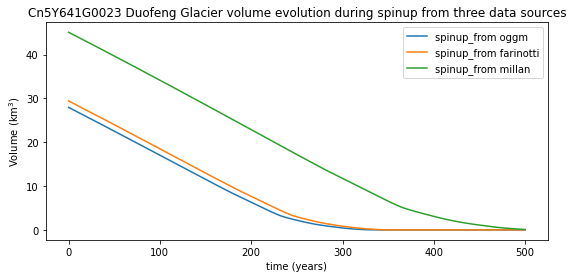

In [47]:
f, ax = plt.subplots(figsize=(9, 4))
for k in range(0,3):
    (d_[k].volume.sum(dim='rgi_id') * 1e-9).plot(ax=ax, label='spinup_from '+data_list[k])

plt.legend()
plt.title(''+gdir.name_corr+' volume evolution during spinup from three data sources')
plt.xlabel('time (years)')
plt.ylabel('Volume ($\mathregular{km^3}$)')
name = ''+gdir.name_corr+'_volume_spinup_nobias.png'
#plt.savefig(name, format = 'png')

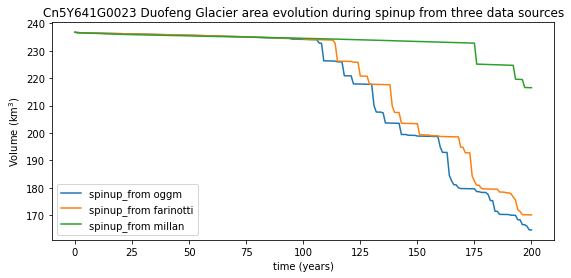

In [80]:
f, ax = plt.subplots(figsize=(9, 4))
for k in range(0,3):
    (d_[k].area.sum(dim='rgi_id') * 1e-6).plot(ax=ax, label='spinup_from '+data_list[k])

plt.legend()
plt.title(''+gdir.name_corr+' area evolution during spinup from three data sources')
plt.xlabel('time (years)')
plt.ylabel('Volume ($\mathregular{km^3}$)')
name = ''+gdir.name_corr+'_area_spinup_m2000.png'
plt.savefig(name, format = 'png')

## Projected volume evolution for different RCP scenarios

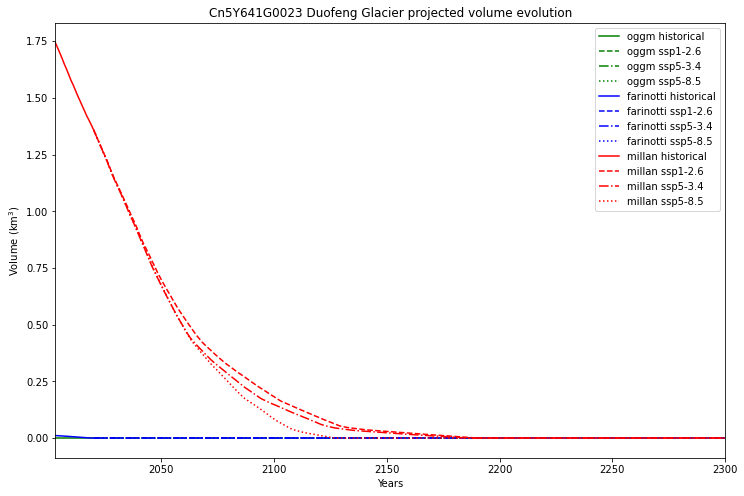

In [12]:
f, ax= plt.subplots(figsize=(12, 8))
ssp=['ssp1-2.6','ssp5-3.4','ssp5-8.5']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"

    (out_hydro_hist[data].volume_m3*10**-9).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,3):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        (out_evol[data][k].volume*10**-9).plot(ax=ax,label=''+data+' '+ssp[k]+'', linestyle=st,color=color_s)

plt.legend(loc='upper right')                    
plt.legend()   
plt.xlim([2003,2300])
plt.title(''+gdir.name_corr+' projected volume evolution')
plt.xlabel('Years')
plt.ylabel('Volume ($\mathregular{km^3}$)')
name = ''+gdir.name_corr+'_evol_volume_ssp_mlater.png'
plt.savefig(name, format = 'png')

### In %

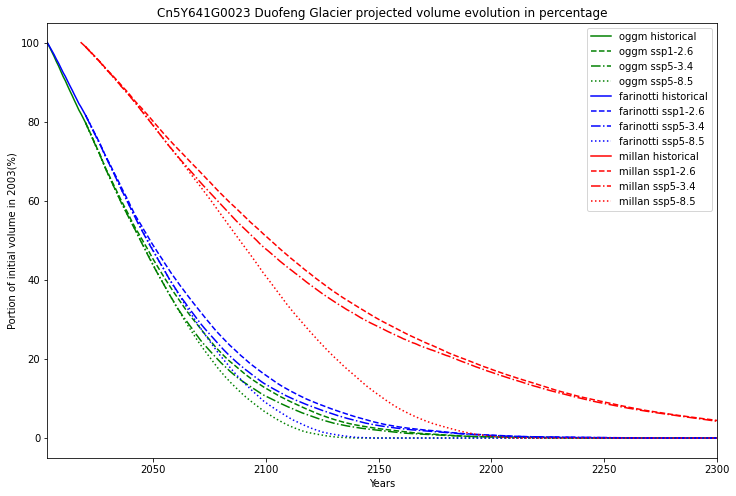

In [23]:
f, ax= plt.subplots(figsize=(12, 8))
ssp=['ssp1-2.6','ssp5-3.4','ssp5-8.5']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"
    if (data=='millan'):
         start_v=np.float64(out_hydro_hist[data].volume_m3.sel(time=[2018]))
    else:
        start_v=np.float64(out_hydro_hist[data].volume_m3.sel(time=[2003]))
    ((out_hydro_hist[data].volume_m3/start_v)*100).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,3):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        ((out_evol[data][k].volume/start_v)*100).plot(ax=ax,label=''+data+' '+ssp[k]+'', linestyle=st,color=color_s)

                    
plt.legend()          
plt.title(''+gdir.name_corr+' projected volume evolution in percentage')
plt.xlabel('Years')
plt.ylabel('Portion of initial volume in 2003(%)')
plt.xlim(2003,2300)
name = ''+gdir.name_corr+'_volume_all_perc_ssp_mlater.png'
plt.savefig(name, format = 'png')

### Rate of annual loss

In [71]:
#2003 : hist 17 & proj 80
#2018 : hist 2 & proj 80
out_hydro_hist[data].volume_m3*10**-9
rate={'farinotti':[0]*17,'millan':[0]*17,'oggm':[0]*17}
rate_rcp={'farinotti':[[0]*280,[0]*280,[0]*280,[0]*280],'millan':[[0]*280,[0]*280,[0]*280,[0]*280],
          'oggm':[[0]*280,[0]*280,[0]*280,[0]*280]}
for data in data_list:
    for t in range(2003,2020):
        rate[data][t-2003]=(np.float64(out_hydro_hist[data].volume_m3.sel(time=[t]))-np.float64(out_hydro_hist[data].volume_m3.sel(time=[t+1])))*10**-9
    for k in range(0,3):
        for t in range(2020,2300):
             rate_rcp[data][k][t-2020]=(np.float64(out_evol[data][k].volume.sel(time=[t]))-np.float64(out_evol[data][k].volume.sel(time=[t+1])))*10**-9

In [72]:
rate_all={'farinotti':0,'millan':0,'oggm':0}
for data in data_list:
    rate_all[data]=rate[data]+rate_rcp[data]

In [73]:
t_r=np.linspace(2003,2299,297)

In [74]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

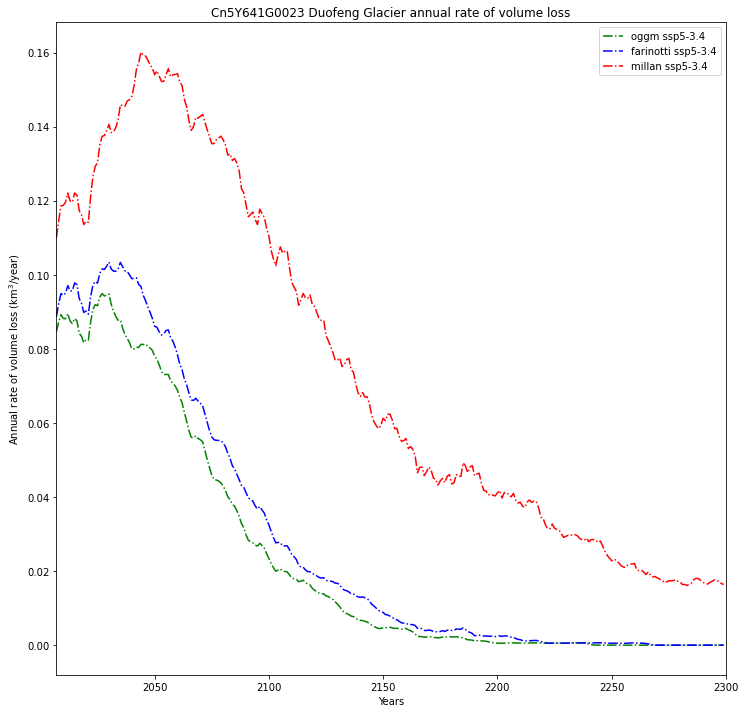

In [77]:
f, ax= plt.subplots(figsize=(12, 12))
ssp=['ssp1-2.6','ssp5-3.4','ssp5-8.5']

for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"
    
    for k in range(1,4,4):
        if (k==0) or (k==3):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        new_rate=rate_all[data][0:17]+rate_all[data][17+k]
        new_rate=moving_average(new_rate,n=5)
        plt.plot(t_r[4:],new_rate,label=''+data+' '+ssp[k]+'', linestyle=st,color=color_s)

                    
plt.legend() 
plt.xlim(2007,2300)
plt.title(''+gdir.name_corr+' annual rate of volume loss')
plt.xlabel('Years')
plt.ylabel('Annual rate of volume loss ($\mathregular{km^3}$/year)')
name = ''+gdir.name_corr+'_rate_vol_lost_534_ssp.png'
plt.savefig(name, format = 'png')

## Projected area evolution for several RCP scenarios

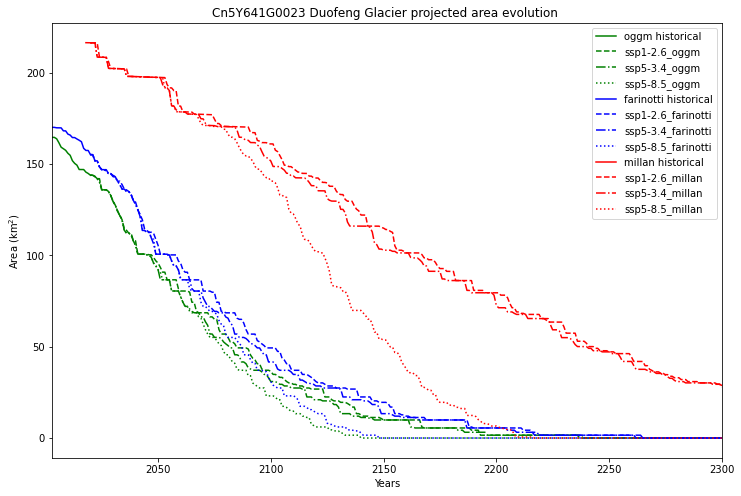

In [24]:
f, ax= plt.subplots(figsize=(12, 8))
ssp=['ssp1-2.6','ssp5-3.4','ssp5-8.5']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"
        
    (out_hydro_hist[data].area_m2*10**-6).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,3):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        (out_evol[data][k].area*10**-6).plot(ax=ax,label=''+ssp[k]+'_'+data, linestyle=st,color=color_s)
        

plt.legend()          
plt.title(''+gdir.name_corr+' projected area evolution ')
plt.xlabel('Years')
plt.xlim(2003,2300)
plt.ylabel('Area ($\mathregular{km^2}$)')
name = ''+gdir.name_corr+'_evol_area_all_ssp_mlater.png'
plt.savefig(name, format = 'png')

## Projected length evolution for several RCP scenarios

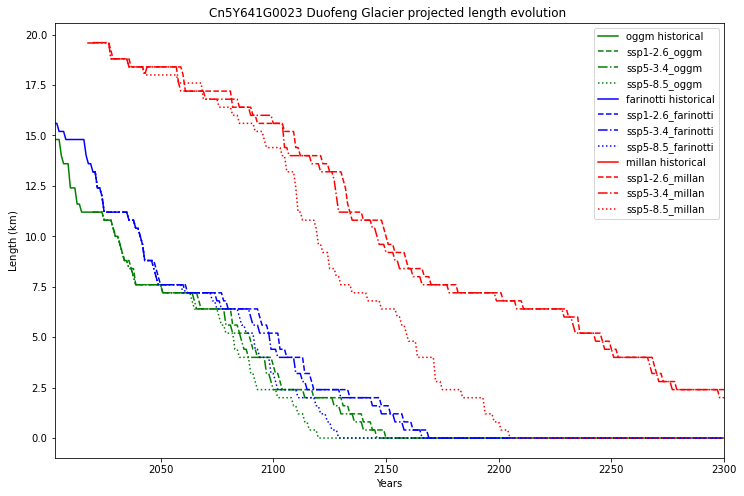

In [25]:
f, ax= plt.subplots(figsize=(12, 8))
ssp=['ssp1-2.6','ssp5-3.4','ssp5-8.5']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"
        
    (out_hydro_hist[data].length_m*10**-3).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,3):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        (out_evol[data][k].length*10**-3).plot(ax=ax,label=''+ssp[k]+'_'+data, linestyle=st,color=color_s)
        

plt.legend()          
plt.title(''+gdir.name_corr+' projected length evolution ')
plt.xlabel('Years')
plt.xlim(2003,2300)
plt.ylabel('Length ($\mathregular{km}$)')
name = ''+gdir.name_corr+'_evol_length_ssp_mlater.png'
plt.savefig(name, format = 'png')


No spinup

## Annual runoff and peak water 

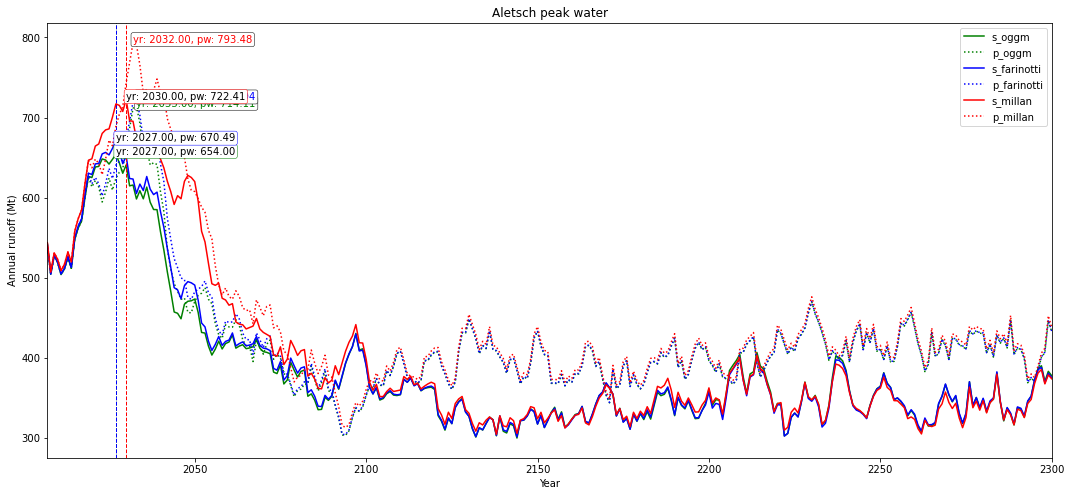

In [81]:
f, ax = plt.subplots(figsize=(18, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']

                
for data in data_list: #loop all data sources
    
    for k in range(0,3,2): #loop all scenarios

        # Select annual variables
        d_p=out_evol[data][k]
        d_h=out_hydro_hist[data]

        sel_vars = [v for v in d_p.variables if 'month_2d' not in d_p[v].dims]
        sel_vars_hist = [v for v in d_h.variables if 'month_2d' not in d_h[v].dims]
        
        # And create a dataframe
        dp_annual = d_p[sel_vars].to_dataframe()
        dh_annual = d_h[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.droplevel('rgi_id')  
        dp_runoff = dp_runoff.drop([2301],axis=0)
        
        dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        dpt_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        # Sum the variables each year "axis=1", take the 11 year rolling mean
        # and plot it.
        year_pw=int(dpt_runoff.sum(axis=1).rolling(window=5).mean().idxmax())
        max_pw=dpt_runoff.sum(axis=1).rolling(window=5).mean().max()
        
        
        #Plotting styles
        if (data=='farinotti'):
            color_s='b'
        elif(data=='millan'):
            color_s='r'
        else:
            color_s='g'
        if (k==0):
            st='-'
        if (k==1):
            st='dashed'
        elif(k==2):
            st=':'
        
        dpt_runoff.sum(axis=1).rolling(window=5).mean().plot(ax=ax, label=''+ssp[k]+'_'+data, linestyle=st,color=color_s)
        if (k==0):
            plt.axvline(year_pw, color=color_s, linestyle='dashed', linewidth=1)
            plt.text(year_pw, max_pw, 'yr: {:.2f}, '.format(year_pw)+'pw: {:.2f}'.format(max_pw),bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color_s, lw=0.5))
        elif (k==2):
            plt.text(year_pw, max_pw, 'yr: {:.2f}, '.format(year_pw)+'pw: {:.2f}'.format(max_pw),color=color_s,bbox=dict(boxstyle="round,pad=0.2", fc="white", ec='k', lw=0.5))
        
        
plt.xlim(2007,2300)
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title(''+gdir.name_corr+' peak water')
plt.legend();
name = ''+gdir.name_corr+'_peak_water_ssp'    
plt.savefig(name, format = 'png')

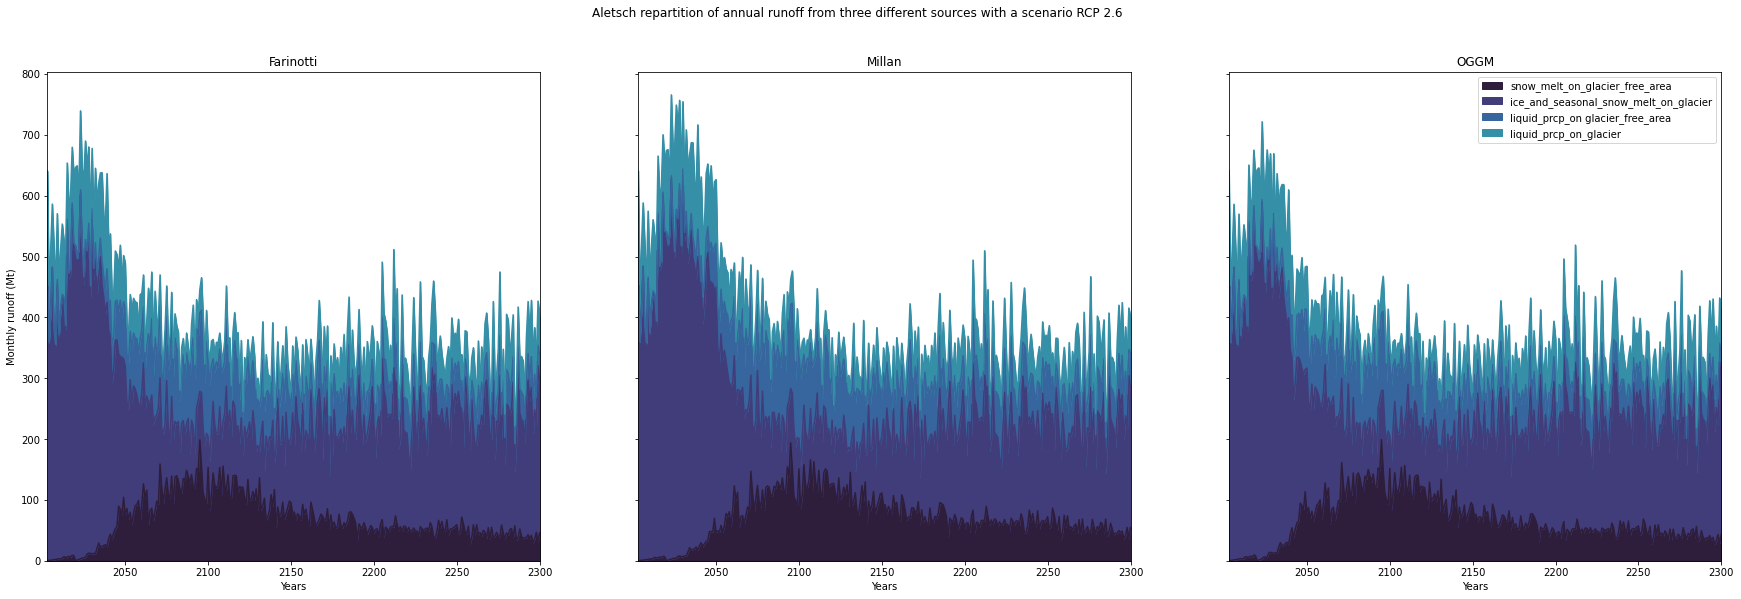

In [82]:
import seaborn as sns
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(30, 9),sharey=True)

for data in data_list: #loop all data sources
    d_p=out_evol[data][0]
    d_ptot=d_p
        
    d_h=out_hydro_hist[data]
    d_htot = d_h

    sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
    sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
    # And create a dataframe
    dp_annual = d_ptot[sel_vars].to_dataframe()
    dh_annual = d_htot[sel_vars_hist].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
    dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
    dp_runoff = dp_runoff.droplevel('rgi_id') 
    dp_runoff = dp_runoff.drop([2301],axis=0)
        
    dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
    dh_runoff = dh_runoff.drop([2020],axis=0)
        
    dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0) #historical and projections in the same Dataframe
    dp_runoff=dp_runoff.rename(columns={ "melt_off_glacier":"snow_melt_on_glacier_free_area",
                              "melt_on_glacier":"ice_and_seasonal_snow_melt_on_glacier",
                              "liq_prcp_off_glacier":"liquid_prcp_on glacier_free_area",
                              "liq_prcp_on_glacier":"liquid_prcp_on_glacier"})
    
    if (data=='farinotti'):
        dp_runoff.plot.area(ax=ax1, legend=False, title='Farinotti', color=sns.color_palette("mako"));
    elif(data=='millan'):
        dp_runoff.plot.area(ax=ax2, legend=False, title='Millan', color=sns.color_palette("mako")); 
    else:
        dp_runoff.plot.area(ax=ax3, title='OGGM', color=sns.color_palette("mako"));

plt.suptitle(''+gdir.name_corr+' repartition of annual runoff from three different sources with a scenario RCP 2.6')
ax1.set_ylabel('Monthly runoff (Mt)'); ax2.set_ylabel('Monthly runoff (Mt)'); ax3.set_ylabel('Monthly runoff (Mt)')
ax1.set_xlabel('Years'); ax2.set_xlabel('Years'); ax3.set_xlabel('Years')
ax1.set_xlim(2003,2300);ax2.set_xlim(2003,2300);ax3.set_xlim(2003,2300)
ax2.set_axis_on()
a=ax1.get_ybound()[1]
b=ax2.get_ybound()[1]
c=ax3.get_ybound()[1]
mm=max(a,b,c)
ax1.set_ylim(bottom=0,top=mm);ax2.set_ylim(bottom=0,top=mm);ax3.set_ylim(bottom=0,top=mm)

name = ''+gdir.name_corr+'_distrib_runoff__126_ssp.png'
plt.savefig(name, format = 'png')

## Plotting profiles

### Initial profil

In [27]:
df_surf=pd.concat([list_out_surf[1],list_out_surf[2],list_out_surf[0]], axis=1)
df_bed=pd.concat([list_out_bed[1],list_out_bed[2],list_out_bed[0]], axis=1)
df_surf.columns=['farinotti','millan','oggm']
df_bed.columns=['bed farinotti','bed millan','bed oggm']

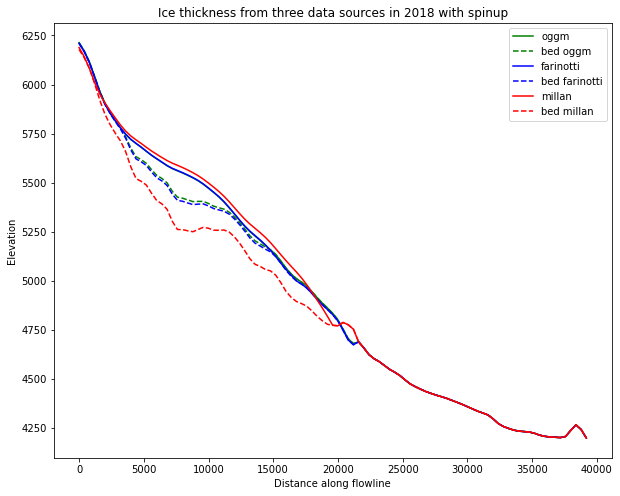

In [29]:
f, ax = plt.subplots(figsize=(10, 8))
for data in data_list:
    if (data=='farinotti'):
        c='b'
    elif (data=='millan'):
        c='r'
    else:
        c='g'
    df_surf[[data]].plot(ax=ax,color=c);
    plt.legend()
    df_bed[['bed '+data+'']].plot(ax=ax,ylabel='Elevation',style="--",color=c);
    plt.legend()
plt.title('Ice thickness from three data sources in 2018 with spinup');
name = ''+gdir.name_corr+'_profil_init_spin_mlater.png'
plt.savefig(name, format = 'png')


### Profile in time for the three data sources

In [82]:
df_surf_farinotti=pd.concat([list_out_surf_evol[1][0],list_out_surf_evol[1][1],list_out_surf_evol[1][2],
                             list_out_surf_evol[1][3],list_out_surf_evol[1][4],list_out_surf_evol[1][5],
                             list_out_surf_evol[1][6],list_out_surf_evol[1][7]],axis=1)
df_surf_millan=pd.concat([list_out_surf_evol[2][0],list_out_surf_evol[2][1],list_out_surf_evol[2][2],
                          list_out_surf_evol[2][3],list_out_surf_evol[2][4],list_out_surf_evol[2][5],
                          list_out_surf_evol[2][6],list_out_surf_evol[2][7]], axis=1)
df_surf_oggm=pd.concat([list_out_surf_evol[0][0],list_out_surf_evol[0][1],list_out_surf_evol[0][2],
                        list_out_surf_evol[0][3],list_out_surf_evol[0][4],list_out_surf_evol[0][5],
                        list_out_surf_evol[0][6],list_out_surf_evol[0][7]], axis=1)

In [83]:
df_surf_f_ex=pd.concat([list_out_surf_evol_ex[1][0],list_out_surf_evol_ex[1][1],list_out_surf_evol_ex[1][2],
                             list_out_surf_evol_ex[1][3],list_out_surf_evol_ex[1][4]],axis=1)
df_surf_m_ex=pd.concat([list_out_surf_evol_ex[2][0],list_out_surf_evol_ex[2][1],list_out_surf_evol_ex[2][2],
                          list_out_surf_evol_ex[2][3],list_out_surf_evol_ex[2][4]], axis=1)
df_surf_o_ex=pd.concat([list_out_surf_evol_ex[0][0],list_out_surf_evol_ex[0][1],list_out_surf_evol_ex[0][2],
                        list_out_surf_evol_ex[0][3],list_out_surf_evol_ex[0][4]], axis=1)

In [84]:
df_surf_f_ex.columns=['2100 farinotti','2150 farinotti','2200 farinotti','2250 farinotti',
                          '2300 farinotti']
df_surf_m_ex.columns=['2100 millan','2150 millan','2200 millan','2250 millan',
                          '2300 millan']
df_surf_o_ex.columns=['2100 oggm','2150 oggm','2200 oggm','2250 oggm',
                          '2300 oggm']

In [85]:
df_bed_2=pd.concat([list_out_bed_evol[1],list_out_bed_evol[2],list_out_bed_evol[0]], axis=1)

In [86]:
df_bed_2.columns=['bed farinotti','bed millan','bed oggm']

In [87]:
df_surf_farinotti.columns=['2020 farinotti','2030 farinotti','2040 farinotti','2050 farinotti',
                          '2060 farinotti','2070 farinotti','2080 farinotti','2090 farinotti']
df_surf_millan.columns=['2020 millan','2030 millan','2040 millan','2050 millan',
                          '2060 millan','2070 millan','2080 millan','2090 millan']
df_surf_oggm.columns=['2020 oggm','2030 oggm','2040 oggm','2050 oggm',
                          '2060 oggm','2070 oggm','2080 oggm','2090 oggm']

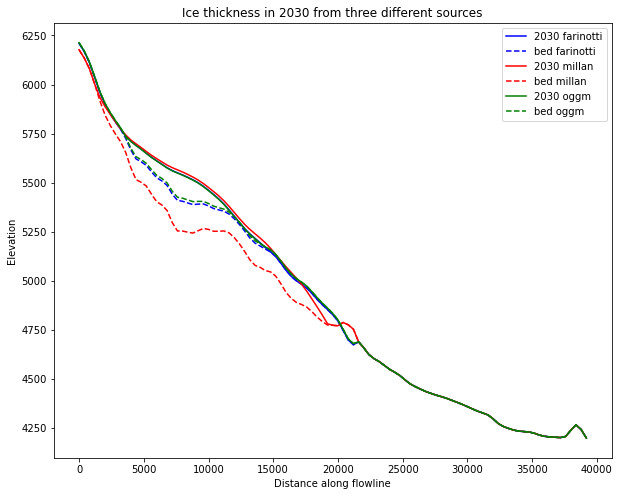

In [94]:
f, ax = plt.subplots(figsize=(10, 8))

df_surf_farinotti[['2030 farinotti']].plot(ax=ax,color='b');
df_bed_2[['bed farinotti']].plot(ax=ax,ylabel='Elevation',style="--",color='b');

df_surf_millan[['2030 millan']].plot(ax=ax,color='r');
df_bed_2[['bed millan']].plot(ax=ax,ylabel='Elevation',style="--",color='r');

df_surf_oggm[['2030 oggm']].plot(ax=ax,color='g');
df_bed_2[['bed oggm']].plot(ax=ax,ylabel='Elevation',style="--",color='g');

plt.legend()
plt.title('Ice thickness in 2030 from three different sources');
name = ''+gdir.name_corr+'_profil_2030_ssp534.png'
plt.savefig(name, format = 'png')

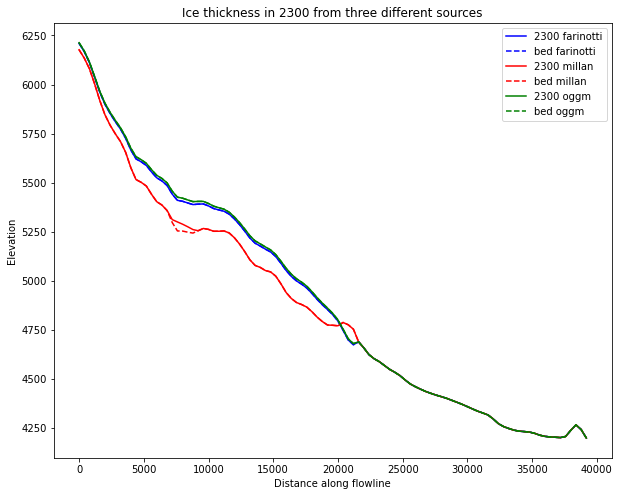

In [91]:
f, ax = plt.subplots(figsize=(10, 8))

df_surf_f_ex[['2300 farinotti']].plot(ax=ax,color='b');
df_bed_2[['bed farinotti']].plot(ax=ax,ylabel='Elevation',style="--",color='b');

df_surf_m_ex[['2300 millan']].plot(ax=ax,color='r');
df_bed_2[['bed millan']].plot(ax=ax,ylabel='Elevation',style="--",color='r');

df_surf_o_ex[['2300 oggm']].plot(ax=ax,color='g');
df_bed_2[['bed oggm']].plot(ax=ax,ylabel='Elevation',style="--",color='g');

plt.legend()
plt.title('Ice thickness in 2300 from three different sources');
name = ''+gdir.name_corr+'_profil_2300_ssp534.png'
plt.savefig(name, format = 'png')

### Plotting climate conditions

In [8]:
cfg.add_to_basenames('gcm_data_MRI-ESM2-0_ssp126','gcm_data_MRI-ESM2-0_ssp126.nc')
cfg.add_to_basenames('gcm_data_MRI-ESM2-0_ssp585','gcm_data_MRI-ESM2-0_ssp585.nc')

In [9]:
with xr.open_dataset(gdir.get_filepath('gcm_data_MRI-ESM2-0_ssp126')) as s26:
    s26 = s26.load()
new26=s26.to_dataframe()
with xr.open_dataset(gdir.get_filepath('gcm_data_MRI-ESM2-0_ssp585')) as s85:
    s85 = s85.load()
new85=s85.to_dataframe()

/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/

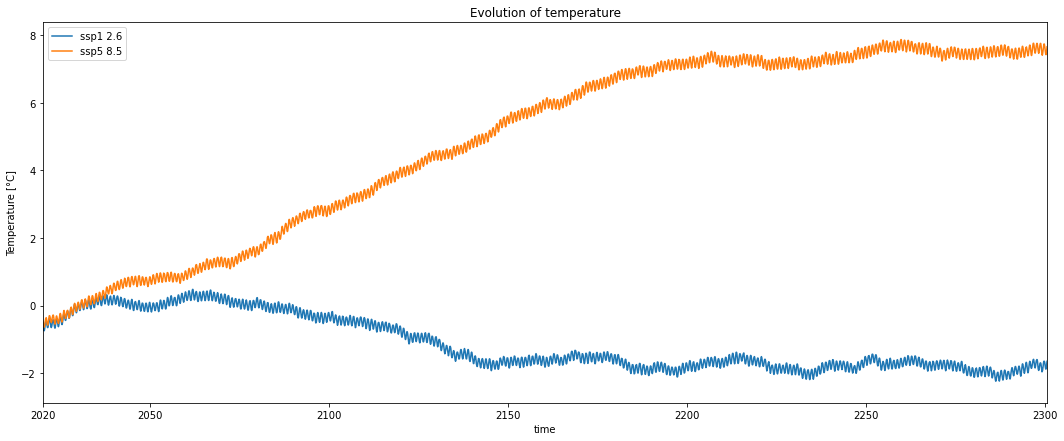

In [60]:
f, ay = plt.subplots(figsize=(18, 7))
new26.temp.rolling(window=200).mean().plot(ax=ay,label='ssp1 2.6')
new85.temp.rolling(window=200).mean().plot(ax=ay,label='ssp5 8.5')
ay.set_xlim([2031,5400])
plt.ylabel('Temperature [°C]')
plt.legend()
plt.xticks([2031,2391,2991,3591,4191,4791,5391], ['2020','2050','2100','2150','2200','2250','2300'])
plt.title('Evolution of temperature')
name = ''+gdir.name_corr+'_temp_proj.png'
plt.savefig(name, format = 'png')

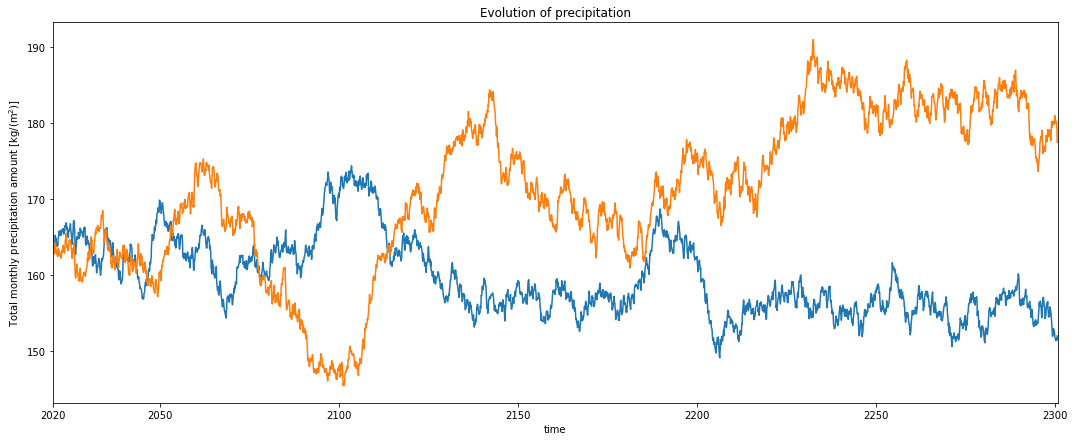

In [59]:
f, ay = plt.subplots(figsize=(18, 7))
new26.prcp.rolling(window=200).mean().plot(ax=ay,label='ssp1 2.6')
new85.prcp.rolling(window=200).mean().plot(ax=ay,label='ssp5 8.5')
ay.set_xlim([2031,5400])
plt.ylabel('Total monthly precipitation amount [kg/($\mathregular{m^2}$)]')
plt.xticks([2031,2391,2991,3591,4191,4791,5391], ['2020','2050','2100','2150','2200','2250','2300'])
plt.title('Evolution of precipitation')
name = ''+gdir.name_corr+'_prcp_proj.png'
plt.savefig(name, format = 'png')